# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
#!pip install smdebug

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter, 
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,   
                            )
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'dogImages'



In [3]:
#inputs = sagemaker_session.upload_data(path='dogImages', bucket=bucket, key_prefix=prefix)
inputs='s3://sagemaker-us-east-1-586887382626/dogImages/'
print("input spec (in this case, just an S3 path): {}".format(inputs)) 

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-586887382626/dogImages/


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [16]:
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py3",
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.2xlarge",
)

In [ ]:
estimator.fit({'training': inputs})

In [17]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
'lr': ContinuousParameter(0.0001, 0.15), 
'batch_size': CategoricalParameter([32, 64, 128, 256, 512])}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [18]:
#TODO: Create estimators for your HPs

#estimator = # TODO: Your estimator here

tuner = HyperparameterTuner(
estimator, 
objective_metric_name,
hyperparameter_ranges,
metric_definitions, 
max_jobs=4, 
max_parallel_jobs=2, 
objective_type=objective_type

)
#TODO: Create your HyperparameterTuner Object

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({'training': inputs}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................................................................................................................................................................................!


In [20]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-02-17 07:58:07 Starting - Preparing the instances for training
2023-02-17 07:58:07 Downloading - Downloading input data
2023-02-17 07:58:07 Training - Training image download completed. Training in progress.
2023-02-17 07:58:07 Uploading - Uploading generated training model
2023-02-17 07:58:07 Completed - Resource reused by training job: pytorch-training-230217-0745-004-2371fd4f


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'lr': '0.002329397097607175',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-17-07-45-41-444"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-586887382626/pytorch-training-2023-02-17-07-45-41-444/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [4]:
from __future__ import absolute_import

import boto3
import pytest
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
    ProfilerRule,
)

In [5]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    ProfilerRule.sagemaker(rule_configs.CPUBottleneck())
]
#hook_config = DebuggerHookConfig(
#    hook_parameters={"train.save_interval": "5", "eval.save_interval": "5"}
#)
debugger_hook_config = DebuggerHookConfig(
    collection_configs=[
          CollectionConfig(
                name="custom_collection",
                parameters={ "include_regex": ".*ReLU_output|.*ResNet_input|.*image|.*NLLLoss",
                             "train.save_interval": "5",
                             "eval.save_interval": "5" })])


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(start_step=1, num_steps=50),
)

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

In [ ]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-projectnew",
    role=role,
    py_version="py3",
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    rules=rules,
    debugger_hook_config=debugger_hook_config, 
    profiler_config=profiler_config
)

estimator.fit({'training': inputs})

2023-02-17 06:47:17 Starting - Starting the training job...
2023-02-17 06:47:42 Starting - Preparing the instances for trainingOvertraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
Overfit: InProgress
ProfilerReport: InProgress
CPUBottleneck: InProgress
...
2023-02-17 06:48:18 Downloading - Downloading input data.........
2023-02-17 06:49:43 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-17 06:49:32,854 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-17 06:49:32,857 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-17 06:49:32,866 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-17 06:49:32,869 sagemaker_pytorch_container.training INFO     Invoking user training script.
202

In [8]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys


trial = create_trial(estimator.latest_job_debugger_artifacts_path())


[2023-02-17 07:38:51.302 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3829 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-586887382626/smdebugger-projectnew-2023-02-17-06-47-17-037/debug-output
[2023-02-17 07:38:51.584 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3829 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4620 more expected)', IncompleteRead(0 bytes read, 4620 more expected)) while reading s3://sagemaker-us-east-1-586887382626/smdebugger-projectnew-2023-02-17-06-47-17-037/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [11]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    #print("loaded TRAIN data", steps_train, vals_train)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    #print("loaded EVAL data", steps_eval, vals_eval)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

completed TRAIN plot
completed EVAL plot


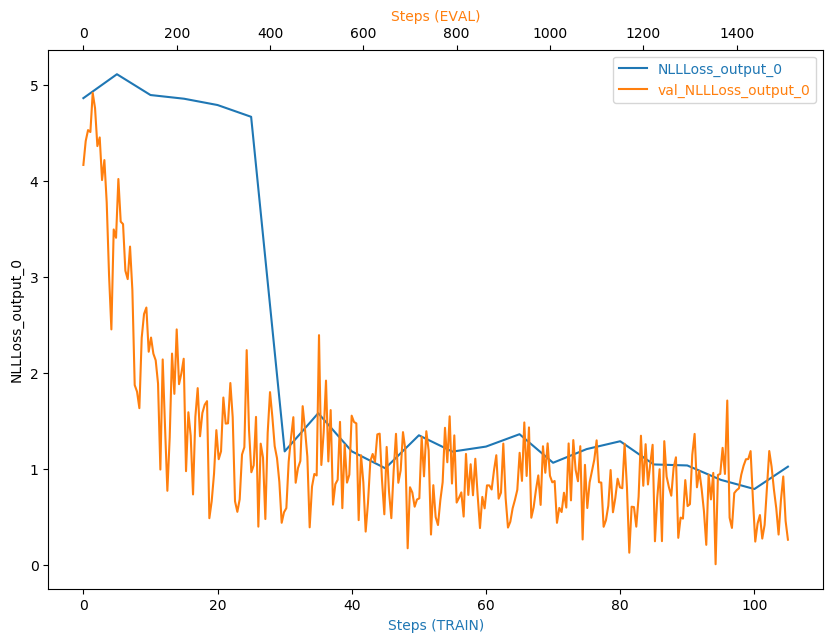

In [15]:
plot_tensor(trial, "NLLLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
#The debugger found that there is a PoorWeightInitialization problem. proper weight initialization will solve this problem
#the debugger also found overtraining issue, and as can be seen on the above plot the loss was not decresing after around the 40th steps, hence early stopping will be 
# a good solution as the model will overfit otherwise.

In [21]:
!pip install jinja2==3.0.3 --force-reinstall


Keyring is skipped due to an exception: 'keyring.backends'
  Using cached Jinja2-3.0.3-py3-none-any.whl (133 kB)
  Using cached MarkupSafe-2.1.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [22]:
# TODO: Display the profiler output
#training_job_name = estimator.latest_training_job.name
training_job_name = "smdebugger-projectnew-2023-02-17-06-47-17-037"
region = 'us-east-1'
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: smdebugger-projectnew-2023-02-17-06-47-17-037
Region: us-east-1


In [23]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-586887382626/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 1, "NumSteps": 50, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 1, "NumSteps": 50, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 1, "NumSteps": 50, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 1, "NumSteps": 50, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 1, "NumSteps": 50, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-586887382626/smdebugger-projectnew-2023-02-17-06-47-17-037/profiler-output


Profiler data from system is available


[2023-02-17 08:24:58.447 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:3829 INFO metrics_reader_base.py:134] Getting 49 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


## Model Deploying

In [24]:
model_location= 's3://sagemaker-us-east-1-586887382626/smdebugger-projectnew-2023-02-17-06-47-17-037/output/model.tar.gz'

In [25]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [26]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [27]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [28]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


------!

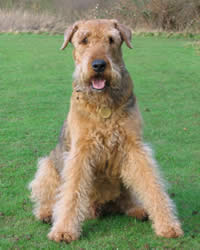

In [29]:
import base64
image_path = 'dogImages/test/003.Airedale_terrier/Airedale_terrier_00179.jpg'
with open(image_path, 'rb') as f:
    image = base64.b64encode(f.read())

image = base64.b64decode(image)
from PIL import Image
import io
Image.open(io.BytesIO(image))

In [30]:
response=predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
import numpy as np
pred = np.argmax(response, 1).item()
print('The predicted class of the dog is ', pred)

The predicted class of the dog is  96


In [31]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

In [32]:
! aws ec2 describe-instance-types 


An error occurred (UnauthorizedOperation) when calling the DescribeInstanceTypes operation: You are not authorized to perform this operation.
